In [1]:
import numpy as np
from numpy import sin, cos, tan, pi
import stl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import vpython as vis
from vpython import vec
import hexy as hx
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.debugger import set_trace as bp
import ipywidgets as widgets
import copy

<IPython.core.display.Javascript object>

# Computing the mirror angles

The basic idea here is that we have an array of mirrors forming a hexagonal grid. Each mirror is located with its centroid at some point in space, and we want for it to reflect a ray of sunlight to a pixel at some location on the ground (or any other focal plane). Since we know where each mirror is, where each corresponding target is, and where the sun is, we can solve for how each mirror needs to be oriented in 3D space in order to reflect the sunlight onto its corresponding target.

Consider just a single mirror and a single target pixel. The center of the mirror has $(x, y, z)$ coordinates located at some vector mirror_pos, and the center of the target pixel is at target_pos. Let's define vectors $\vec{u}, \vec{v}$ such that $\vec u =$mirror_pos - target_pos is the vector pointing from the target to the mirror center, and $\vec v = \left(\sin \phi, \cos \phi \sin \theta, \cos \phi \cos \theta\right)$ is the vector pointing in the direction of the sun (a point source placed at infinity). Here we're assuming the sun is at an inclination of $\theta$ from the horizon and that the azimuthal angle relative to the mirror is $latex \phi$. 

Since the reflected angles are the same as the incident angles for a mirror, the normal vector $\hat n$ of the mirror just needs to bisect these two vectors $\vec u$ and $\vec v$, so we have that $\hat n = \frac{\vec v}{|| \vec v ||} - \frac{\vec u}{|| \vec u ||}$:

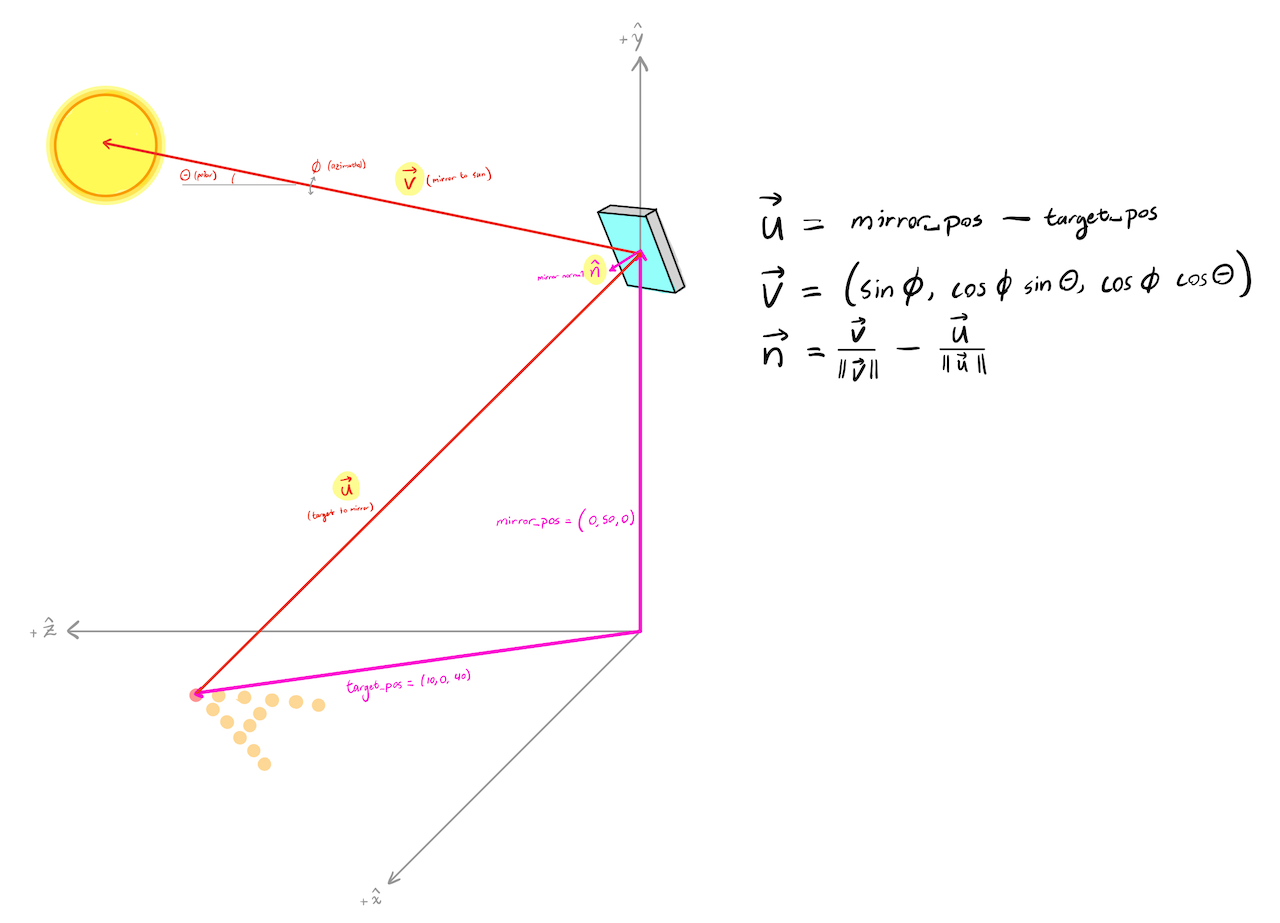

In [2]:
def compute_mirror_normal(mirror_pos, target_pos, sun_azimuth_θ, sun_angle_ϕ = 0.0):
    """Returns a unit normal vector for the mirror to shine light on a target position"""
    
    v_target_mirror = mirror_pos - target_pos

    θ = sun_azimuth_θ
    ϕ = sun_angle_ϕ
    v_mirror_sun = np.array([sin(ϕ), cos(ϕ) * sin(θ), cos(ϕ) * cos(θ)])

    mirror_normal = normalize(v_mirror_sun) - normalize(v_target_mirror)
    return normalize(mirror_normal)
    

# Generating a 3D model of a hexagonal prism

A 3D model is just a list of vertices and faces. The vertices are the corners of the polygon (a list of 3D coordinates) and the faces are a list of triangular facets, where each face is specified by tuple containing the indices of three vertices. So to generate the 3D model of the hexagonal prism, I just needed to compute the coordinates for the corners of the prism and the define triangular facets that form the outer faces of the prism.

The 3D printed plastic frame of the mirror array is made up of a grid of hexagonal prisms. Each hexagonal prism has its base on the $latex (x,y)$ plane and has a position $latex \vec p$ specified by the location of the centroid of the top face (coordinate 7 in the left image), which is normal to the vector $latex \hat n$. To compute the coordinates for the top corners, I computed the intersection of the plane defined by $latex \vec p, \vec n$ and the vector pointing vertically from each corner of the base (right image). I then just used a hard-coded list of vertex indices to specify the faces (so, for example, one face is (0,5,6), while another is (5,12,13) when referring to the left image).

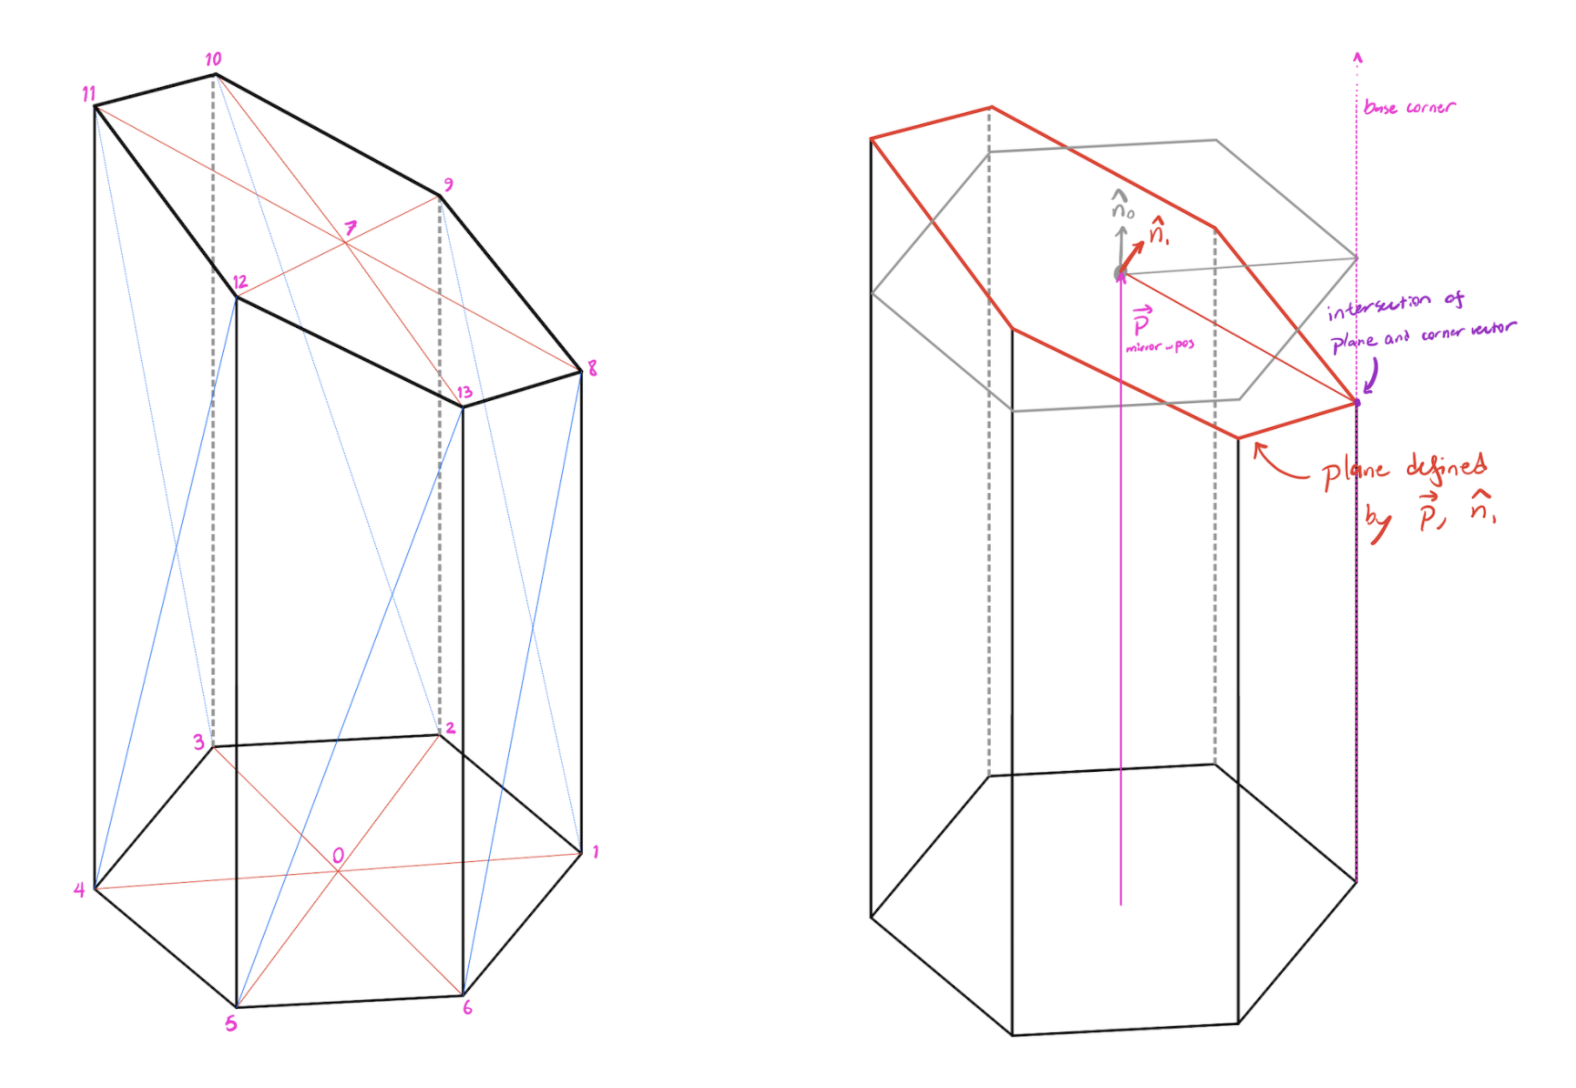

Another thing I included in this function was the ability to add a mirror aligner structure to the prism. This mirror aligner is a small protrusion on two sides of the hex prism which fits on a corner of the hexagonal mirrors, which makes it much less tedious to glue hundreds of mirrors to the final structure (right image below). A subtle detail here is that the coordinates of the mirror aligner are not collinear with the coordinates of the top corners of the hex prism: the mirror aligner always needs to make a $120^\circ$ angle, but if the hex prism has a top surface with a steep slope, the corner angles get distorted. So to compute the coordinates of the mirror aligner, I computed the projection of the x axis onto the plane of the the top of the prism as $\hat{x}' = \hat y \times \hat n$. Then I rotated this vector about the normal vector $\hat n$ by increments of $2 \pi / 6$ to get the corners of the aligner.

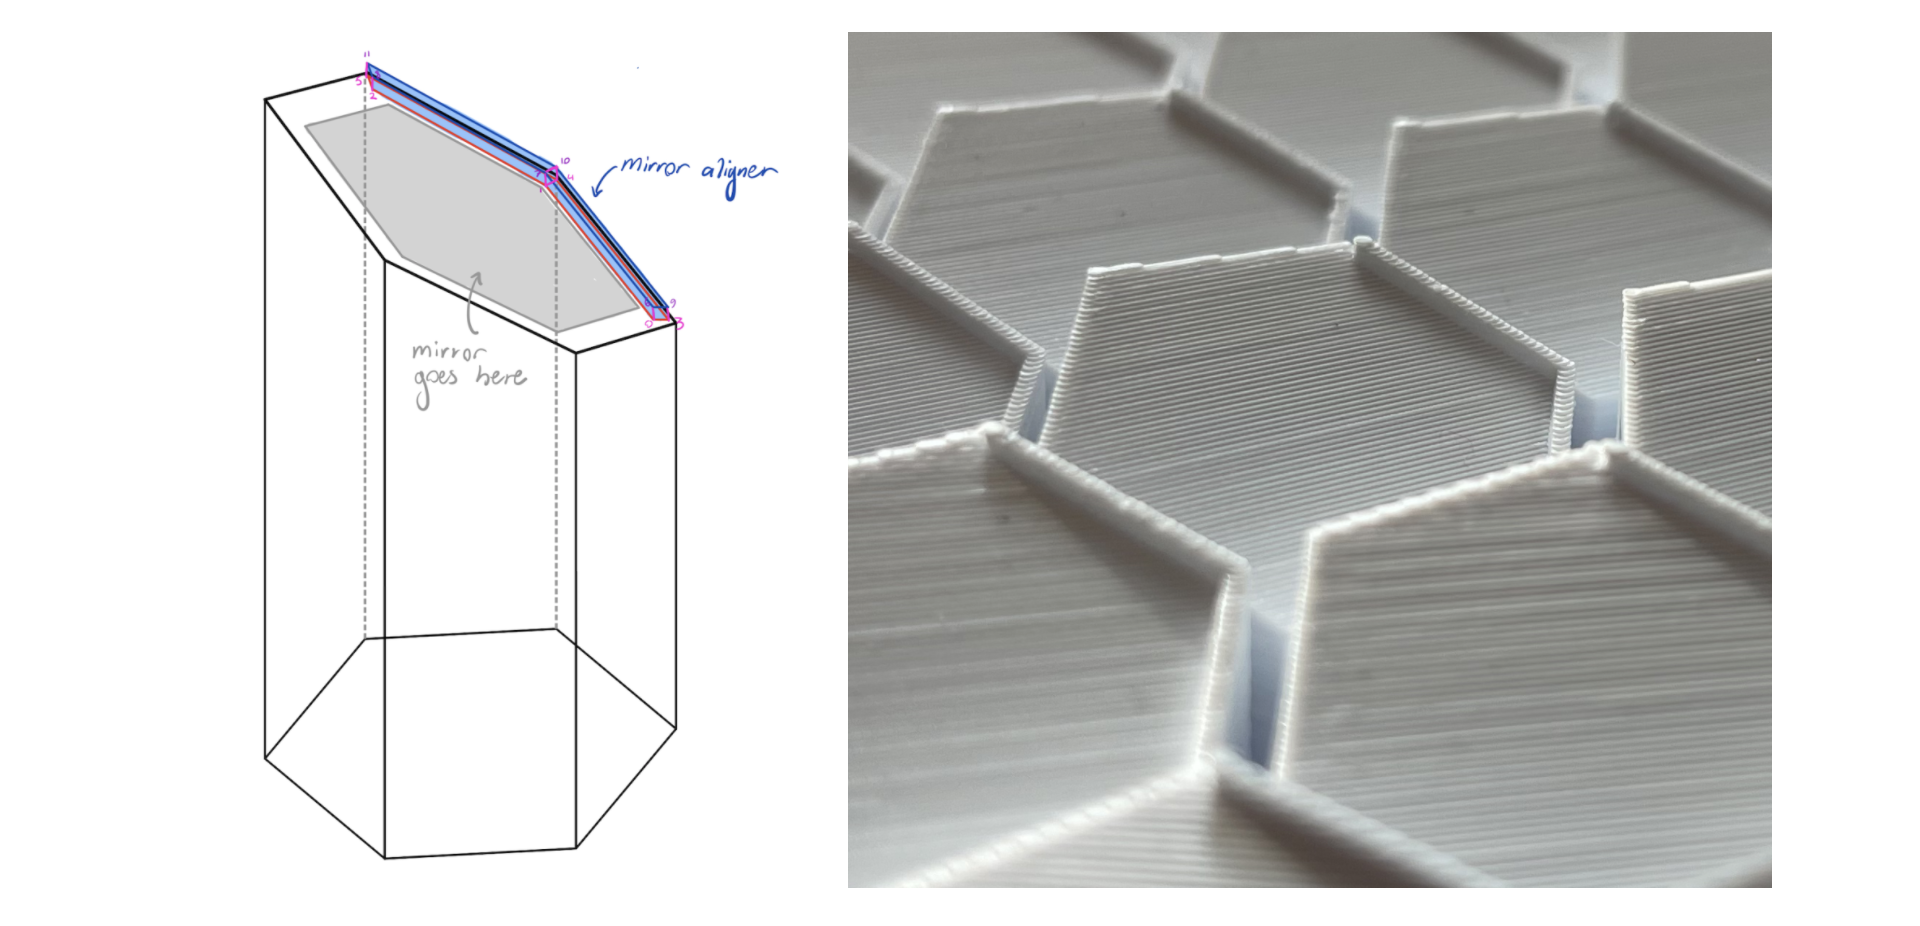

In [3]:
## These functions copied from https://stackoverflow.com/questions/5666222/3d-line-plane-intersection

def intersection_line_plane(p0, p1, p_co, p_no, epsilon=1e-9):
    """
    p0, p1: Define the line.
    p_co, p_no: define the plane:
        p_co Is a point on the plane (plane coordinate).
        p_no Is a normal vector defining the plane direction;
             (does not need to be normalized).

    Return a Vector or None (when the intersection can't be found).
    """
    
    def add_v3v3(v0, v1):
        return (v0[0] + v1[0], v0[1] + v1[1], v0[2] + v1[2])

    def sub_v3v3(v0, v1):
        return (v0[0] - v1[0], v0[1] - v1[1], v0[2] - v1[2])

    def dot_v3v3(v0, v1):
        return ((v0[0] * v1[0]) + (v0[1] * v1[1]) + (v0[2] * v1[2]))

    def len_squared_v3(v0):
        return dot_v3v3(v0, v0)

    def mul_v3_fl(v0, f):
        return (v0[0] * f, v0[1] * f, v0[2] * f)

    u = sub_v3v3(p1, p0)
    dot = dot_v3v3(p_no, u)

    if abs(dot) > epsilon:
        # The factor of the point between p0 -> p1 (0 - 1)
        # if 'fac' is between (0 - 1) the point intersects with the segment.
        # Otherwise:
        #  < 0.0: behind p0.
        #  > 1.0: infront of p1.
        w = sub_v3v3(p0, p_co)
        fac = -dot_v3v3(p_no, w) / dot
        u = mul_v3_fl(u, fac)
        return add_v3v3(p0, u)
    else:
        # The segment is parallel to plane.
        return None

In [4]:
def rad_from_deg(deg):
    return deg * np.pi / 180

def normalize(v):
    return v / np.linalg.norm(v)


def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = cos(theta / 2.0)
    b, c, d = -axis * sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [5]:
def create_hex_prism(center_pos_vec, normal_vec, triangle_radius, add_mirror_aligners=False, aligner_inner_radius=None, aligner_thickness=0.5):
    """
    Creates a hexagonal prism mesh. 
    Assumptions:
    - Base plane is at z=0
    - Triangle radius is center-to-corner and points in +/- x direction
    """

    # Create base vertices
    base_center = [center_pos_vec[0], center_pos_vec[1], 0.0]
    base_corners = [
        base_center + (triangle_radius * (rotation_matrix([0,0,1], θ) @ np.array([1,0,0])))
        for θ in 2*pi/6 * np.arange(6)
    ]
    base_vertices = np.array([base_center, *base_corners])

    # Create top vertices 
    top_center = np.copy(center_pos_vec)
    # top_corners = [[v[0], v[1], 1000.0] for v in base_corners]
    top_corners = np.array([intersection_line_plane(v, [v[0], v[1], 1000.0], center_pos_vec, normal_vec) for v in base_corners])
    top_vertices = np.array([top_center, *top_corners])

    # Create the mesh vertices and faces
    vertices = np.array([*base_vertices, *top_vertices])
    bottom_faces = [
        [0,1,2],
        [0,2,3],
        [0,3,4],
        [0,4,5],
        [0,5,6],
        [0,6,1]
    ]
    top_faces = [
        [7,8,9],
        [7,9,10],
        [7,10,11],
        [7,11,12],
        [7,12,13],
        [7,13,8]
    ]
    side_faces = [
        [1,9,2],  [1,8,9],
        [2,10,3], [2,9,10],
        [3,11,4], [3,10,11],
        [4,12,5], [4,11,12],
        [5,13,6], [5,12,13],
        [6,1,8],  [6,13,8]
    ]
    faces = np.array([*bottom_faces, *top_faces, *side_faces])

    # Create the mesh
    hex_prism = stl.mesh.Mesh(np.zeros(faces.shape[0], dtype=stl.mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            hex_prism.vectors[i][j] = vertices[face[j],:]
            
    # Add alignment ridges to place mirrors into
    if add_mirror_aligners:
        if aligner_inner_radius is None:
            raise ValueError("Need to specify alignemnt radius!")
            
        aligner_outer_radius = aligner_inner_radius + aligner_thickness
        if aligner_outer_radius > triangle_radius:
            raise ValueError("Aligner thickness plus width too large!")
            
        # Create base vertices
        aligner_center = np.copy(center_pos_vec)
        x_plus_on_face = normalize(np.cross(np.array([0,1,0]), normal_vec))
        aligner_inner_corners = [
            aligner_center + aligner_inner_radius * (rotation_matrix(normal_vec, θ) @ x_plus_on_face)
            for θ in 2*pi/6 * np.array([-1,0,1])
        ]
        aligner_outer_corners = [
            aligner_center + aligner_outer_radius * (rotation_matrix(normal_vec, θ) @ x_plus_on_face)
            for θ in 2*pi/6 * np.array([-1,0,1])
        ]
        aligner_bottom_vertices = np.array([*aligner_inner_corners, *aligner_outer_corners])
        
        unit_normal_vec = normal_vec / np.linalg.norm(normal_vec)
        aligner_top_vertices = aligner_bottom_vertices + (aligner_thickness * unit_normal_vec)
        
        aligner_vertices = np.array([*aligner_bottom_vertices, *aligner_top_vertices])
        aligner_bottom_faces = [
            [0,1,3],
            [3,1,4],
            [1,2,5],
            [1,5,4]
        ]
        aligner_top_faces = list(np.array(aligner_bottom_faces) + 6)
        aligner_side_faces = [
            [8,2,11],
            [2,11,5],
            [8,2,7],
            [2,1,7],
            [1,7,0],
            [7,6,0],
            [0,6,9],
            [0,3,9],
            [3,9,10],
            [3,4,10],
            [4,10,5],
            [10,5,11]
        ]
        aligner_faces = np.array([*aligner_bottom_faces, *aligner_top_faces, *aligner_side_faces])
        # Create the mesh
        aligner_mesh = stl.mesh.Mesh(np.zeros(aligner_faces.shape[0], dtype=stl.mesh.Mesh.dtype))
        for i, face in enumerate(aligner_faces):
            for j in range(3):
                aligner_mesh.vectors[i][j] = aligner_vertices[face[j],:]
       
        # Fuse with hex prism
        hex_prism = fuse_models([hex_prism, aligner_mesh])
            
    return hex_prism

def fuse_models(models):
    all_data = np.concatenate([model.data.copy() for model in models])
    return stl.mesh.Mesh(all_data)

In [6]:
center_pos_vec1 = 10 * np.array([0,0,5])
normal_vec1 = 10 * np.array([.5,0,1])
triangle_radius1 = 10.0

hex_prism_1 = create_hex_prism(center_pos_vec1, normal_vec1, triangle_radius1, add_mirror_aligners=False, aligner_inner_radius=triangle_radius1-1.0)

center_pos_vec2 = 10 * np.array([0,2 * np.sin(rad_from_deg(60)),5])
normal_vec2 = 10 * np.array([-1,0,1])
triangle_radius2 = 10.0

hex_prism_2 = create_hex_prism(center_pos_vec2, normal_vec2, triangle_radius2)

prisms = fuse_models([hex_prism_1, hex_prism_2])

hex_prism_1.check() 
hex_prism_1.save("hex_prism.stl")

# # Test visualize
# plt.scatter(top_vertices.T[0], top_vertices.T[1])
# plt.axis("equal")
# plt.show()

# Generating a hexagonal grid of prisms

In [7]:
def get_hex_grid_centers(num_hexes_radius, mini_hex_radius):
    """Creates a large hexagonal array of mini-hexagons. Returns the centerpoint for each"""
    coords = hx.get_spiral(np.array((0, 0, 0)), 1, num_hexes_radius) # The center is in hexagonal, "fake", xyz cubic coordinates
    x, y = hx.cube_to_pixel(coords, mini_hex_radius).T
    centers = np.array([y, x]).T
    return centers

def mirror_pos_from_xy_base(center, base_height=20, distance_scaling=0.0, x_offset=0.0, y_offset=0.0):
    """Converts xy coordinates of a base to xyz coordinates of mirror centers"""
    distance_from_center = np.linalg.norm(center)
    height = base_height + distance_scaling * distance_from_center
    center_vec = np.array([center[0] + x_offset, center[1] + y_offset, height])
    return center_vec

def make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True, x_offset=0.0, y_offset=0.0, verbose=True, no_fuse_models=False):
    all_prisms = []
    for mirror_pos, mirror_normal in zip(mirror_positions, mirror_normals):
        hex_prism = create_hex_prism(mirror_pos, mirror_normal, mini_hex_radius, add_mirror_aligners=add_mirror_aligners, aligner_inner_radius=mini_hex_radius-1.0, aligner_thickness=1.0)
        all_prisms.append(hex_prism)
    if verbose:
        print("Created model with {} hex prisms".format(len(all_prisms)))
    if no_fuse_models:
        return all_prisms
    else:
        return fuse_models(all_prisms)

In [8]:
coords = hx.get_spiral(np.array((0, 0, 0)), 1, 3)
x, y = hx.cube_to_pixel(coords, 1).T
points = np.array([y, x]).T

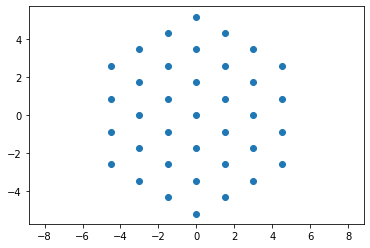

In [9]:
def plot_hex_points(points, num=len(points)):
    # Test visualize
    plt.scatter(points.T[0][0:num], points.T[1][0:num])
    plt.axis("equal")
    plt.show()
    
plot_hex_points(points)
# interact(plot_hex_points(points), num=len(points))

# Test: aligning the mirrors to a single point in 3D space

In [10]:
target_pos = np.array([0, 0, 40])

θ = np.deg2rad(0) # This is the angle with respect to the XY plane, normal to the overall structure
ϕ = np.deg2rad(0)

grid_hex_radius = 2
mini_hex_radius = 10

hex_centers = get_hex_grid_centers(grid_hex_radius, mini_hex_radius)
mirror_positions = [mirror_pos_from_xy_base(center, base_height=20, distance_scaling=.2) for center in hex_centers]
mirror_normals = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for mirror_pos in mirror_positions]

hex_prism_grid = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius * .9)


base_positions = [mirror_pos_from_xy_base(center, base_height=5, distance_scaling=0) for center in hex_centers]
base_normals = np.tile(np.array([0,0,1]), (len(hex_centers),1))
hex_prism_bases = make_hex_prism_grid(base_positions, base_normals, mini_hex_radius * 1.1, add_mirror_aligners=False)

hex_prism_grid_combined = fuse_models([hex_prism_grid, hex_prism_bases])

hex_prism_grid_combined.save("hex_prism_grid_single_focus.stl")

Created model with 19 hex prisms
Created model with 19 hex prisms


# Formatting coordinates for an image 

This section generates and formats the set of 2D coordinates that define the image you would like to project, and can transform them to 3D coordinates on the focal plane.

In [11]:
mirror_diameter = 2 * ((10 * 2.5 / 2) + 1) # +1 for aligner
base_padding = 1.1
diameter_r8 = .5 * (mirror_diameter * base_padding * (np.sqrt(3) * (2*(8)+1)))

(169, 2)


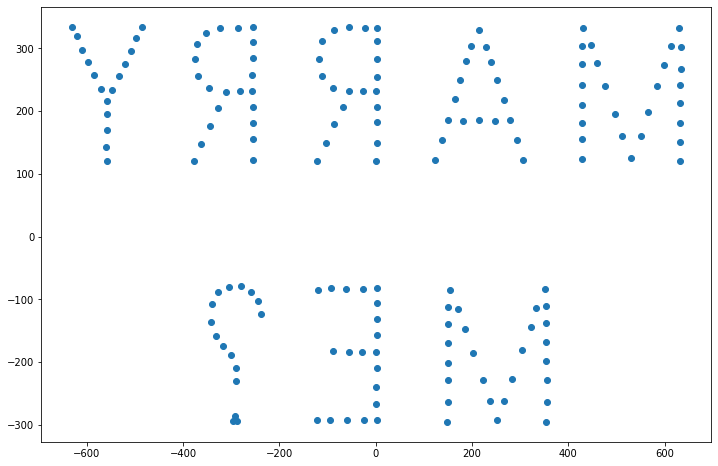

In [12]:
# Pasted from mathematica output
coords = [[749.67, 438.1], [1204.75, 469.56], [546.35, 438.88], [1275.28, 832.91], [1017.78, 833.74], [647.6295776367188, 799.1300964355469], [724.099609375, 799.9089050292969], [266.5836181640625, 817.9267272949219], [472.28, 825.59], [749.72, 380.21], [545.87, 382.16], [452.72, 854.7], [286.96, 853.25], [715., 402.43], [268.17, 763.19], [566.45, 435.89], [728.47, 434.11], [1216.48, 375.58], [1187.9737548828125, 256.1741943359375], [1195.5775146484375, 256.1741943359375], [1192.04, 263.91], [1190.316650390625, 319.66131591796875], [1190.37, 339.86], [1200.08, 360.98], [1232.17, 392.32], [1242.01, 414.51], [1240.2, 442.8], [1226.76, 460.95], [1179.57, 470.69], [1158.2, 461.2], [1144.78, 446.96], [1138.196044921875, 426.24267578125], [897.4918823242188, 418.1148681640625], [926.57, 467.27], [960.62, 466.59], [993.49, 467.39], [927.3, 366.3], [956.21, 365.58], [993.6444091796875, 257.5711669921875], [958.5223388671875, 257.8609619140625], [924.378173828125, 258.04620361328125], [898.84, 282.62], [898.1, 310.38], [896.8499755859375, 340.74298095703125], [897.62, 392.57], [897.430908203125, 443.7537841796875], [898.8089599609375, 366.19598388671875], [1019.248291015625, 465.7032470703125], [988.32, 367.04], [1022.5699462890625, 257.55078125], [898.09, 257.23], [897.6317138671875, 467.7864990234375], [545.9, 412.09], [578.06, 406.69], [471.71, 759.91], [749.8, 410.35], [749.28, 348.51], [697.87, 364.76], [595.89, 369.18], [545.29, 351.59], [544.24755859375, 320.94464111328125], [615.7874755859375, 323.77764892578125], [677.2498168945312, 322.1021728515625], [749.7682495117188, 321.30474853515625], [750.0340576171875, 286.13226318359375], [661.3663940429688, 288.0025634765625], [633.14208984375, 288.0025634765625], [544.21484375, 286.75433349609375], [751.0889892578125, 255.06298828125], [745.34, 465.11], [647.705078125, 257.4637451171875], [548.85, 467.3], [545.132568359375, 254.5081787109375], [1484.33, 806.92], [1433.8072509765625, 805.7794647216797], [1459.27, 692.7], [1458.76, 719.32], [1457.575439453125, 745.1332092285156], [1397.06, 866.63], [1408.35, 846.25], [1421.2, 825.46], [1446.67, 784.15], [1469.96, 785.14], [1497.03, 828.66], [1508.74, 848.17], [1520.617919921875, 869.9008636474609], [1458.5758056640625, 766.6499633789062], [1530.668212890625, 884.5923004150391], [1384.2706298828125, 883.6441497802734], [1458.09423828125, 671.2614135742188], [1185.76, 882.84], [1223.1552734375, 882.6755676269531], [1251.27, 875.17], [1270.83, 857.79], [1268.17431640625, 805.2270812988281], [1245.04, 787.51], [1181.78, 781.8], [1211.3526611328125, 781.2495880126953], [1226.75, 754.47], [1244.0364990234375, 725.6549987792969], [1261.5723876953125, 697.1242370605469], [1277.6258544921875, 671.0181884765625], [1155.409912109375, 672.613037109375], [1155.4261474609375, 704.9848327636719], [1155.4664306640625, 730.7848815917969], [1155.3052978515625, 756.4649353027344], [1155.66796875, 781.4039306640625], [1155.81, 807.5], [1154.74, 834.85], [1154.44, 860.99], [1154.1702880859375, 883.5802764892578], [897.8416748046875, 804.0701904296875], [897.5758666992188, 833.1923522949219], [897.0039672851562, 861.1928863525391], [922.34, 882.96], [955.9832153320312, 883.3663787841797], [985.98, 879.14], [1010.79, 862.27], [1012.2882080078125, 805.221923828125], [987.794921875, 786.5226898193359], [925.7581787109375, 781.9527893066406], [897.406982421875, 756.2396545410156], [968.6502685546875, 757.0301513671875], [986.75, 729.44], [897.3654174804688, 732.0417785644531], [897.139892578125, 698.6778564453125], [1003.6195068359375, 698.6194152832031], [955.4535522460938, 782.1603088378906], [898.4556884765625, 781.937255859375], [897.9386596679688, 882.872314453125], [1021.3914794921875, 670.7004699707031], [898.5322875976562, 671.0590209960938], [651.59, 734.93], [717.95, 734.58], [762.74, 703.86], [605.9717407226562, 703.7068481445312], [634.17, 767.06], [735.34, 769.67], [712.33, 830.17], [660.43, 828.6], [671.5, 851.59], [702.06005859375, 853.2278900146484], [749.8562622070312, 736.0979309082031], [621.53, 736.07], [685.41, 735.23], [685.58, 879.34], [776.983154296875, 672.78271484375], [593.150146484375, 671.5205993652344], [268.43, 700.08], [349.78631591796875, 709.9300231933594], [389.09, 710.53], [471.39, 705.05], [471.59, 731.2], [402.43, 746.08], [334.43, 747.92], [267.55, 731.3], [266.57, 851.98], [301.76, 822.9], [439.2, 827.33], [470.74, 853.1], [471.35, 791.46], [422.74, 789.53], [316.13, 789.57], [267.87, 791.82], [471.3092041015625, 673.2996826171875], [469.02, 882.34], [369.4679870605469, 675.087646484375], [270.44, 881.96], [267.99627685546875, 670.501220703125]]
coords = np.array(coords)

coords -= np.array([900,550])
coords *= 120 / 1200 # width of about 48 inches
coords *= 10 # cm to mm

coords *= np.array([-1,1]) # IMPORTANT: need to mirror the array!

print(coords.shape)

plt.figure(figsize=(12,8))
plt.scatter(coords.T[0], coords.T[1])
plt.show()

(37, 2)


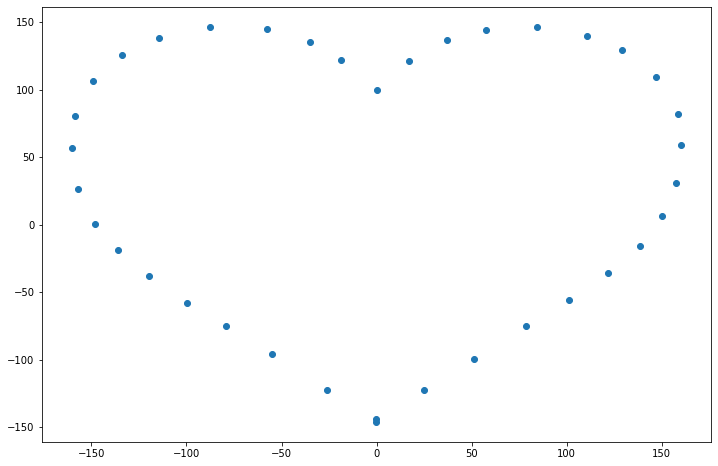

In [13]:
coords_heart = [[599.4664306640625, 119.61083984375], [683.27, 190.94], [512.4031982421875, 192.084716796875], [1101.1800537109375, 620.8414306640625], [1133.19, 796.36], [66., 790.18], [105.59696960449219, 601.76708984375], [201.69, 473.63], [1006.43, 481.81], [1090.34, 965.27], [101.91, 954.78], [536.77880859375, 1007.7824401855469], [656.955078125, 1004.5348815917969], [724., 1055.37], [482.96, 1051.51], [407.31, 1082.43], [791.62, 1080.77], [969.3441162109375, 1067.0575714111328], [218.079345703125, 1061.4600219726562], [154.13, 1019.47], [1030.3, 1030.55], [1124.528564453125, 704.10302734375], [76.73, 689.26], [416.39, 281.09], [770.11, 268.22], [336.1, 349.31], [862.73, 349.14], [936.64, 413.03], [267.752685546875, 407.59344482421875], [146.53, 537.92], [1061.13, 546.2], [1127.97, 874.39], [71.11, 869.47], [307.07, 1087.15], [880.68, 1088.85], [600.4229736328125, 931.498046875], [599.6448974609375, 112.80242919921875]]
coords_heart = np.array(coords_heart)

coords_heart -= np.array([600,600])
coords_heart *= 15 / 500
coords_heart *= 10 # cm to mm

print(coords_heart.shape)

plt.figure(figsize=(12,8))
plt.scatter(coords_heart.T[0], coords_heart.T[1])
plt.show()

In [14]:
focal_plane_default = 6 * 304.8 # 6 feet in mm

vertical_distance_default = 46 * 25.4 # 46 inch in mm
horizontal_distance_default = 46 * 25.4 # 46 inch in mm
        
def create_target_positions_wall(target_coordinates, depth = focal_plane_default):
    target_positions = np.array([[c[0], c[1], depth] for c in target_coordinates])
    return target_positions

def create_target_positions_ground(target_coordinates, 
                                   vertical_distance=vertical_distance_default, 
                                   horizontal_distance=horizontal_distance_default):
    target_positions = np.array([[c[0], -1 * vertical_distance, c[1] + horizontal_distance] for c in target_coordinates])
    return target_positions

# Aligning the mirrors to a set of 3D points

One of the more interesting problems to solve in this project was how to optimally match target light spots to corresponding mirrors to maximize the focal distance tolerance. (So that you can hold the structure at a slightly incorrect distance or orientation from the focal plane and it will still reflect a legible message.) 

The mirror array will project a set of rays onto the focal plane to form an image, and when the structure is placed at exactly the right angle and distance from the focal plane, the image will (in theory) be exactly what you want it to be. But if you deviate from this height or angle, the image will slightly deform. However, you can mitigate this by making the rays as parallel as possible, so as to minimize any times where rays will cross each other before the focal plane.

Consider the following scenario in the figure below. There are four mirrors projecting light rays onto four targets which form a diamond formation when placed at the proper focal distance. On the left side, two of the rays will cross each other, while on the right side, the rays are closer to parallel and do not cross. If you move the focal plane relative to the mirror array, the left image will distort, becoming vertically squished, while the right image does not significantly distort (the points remain in the same relative configuration).

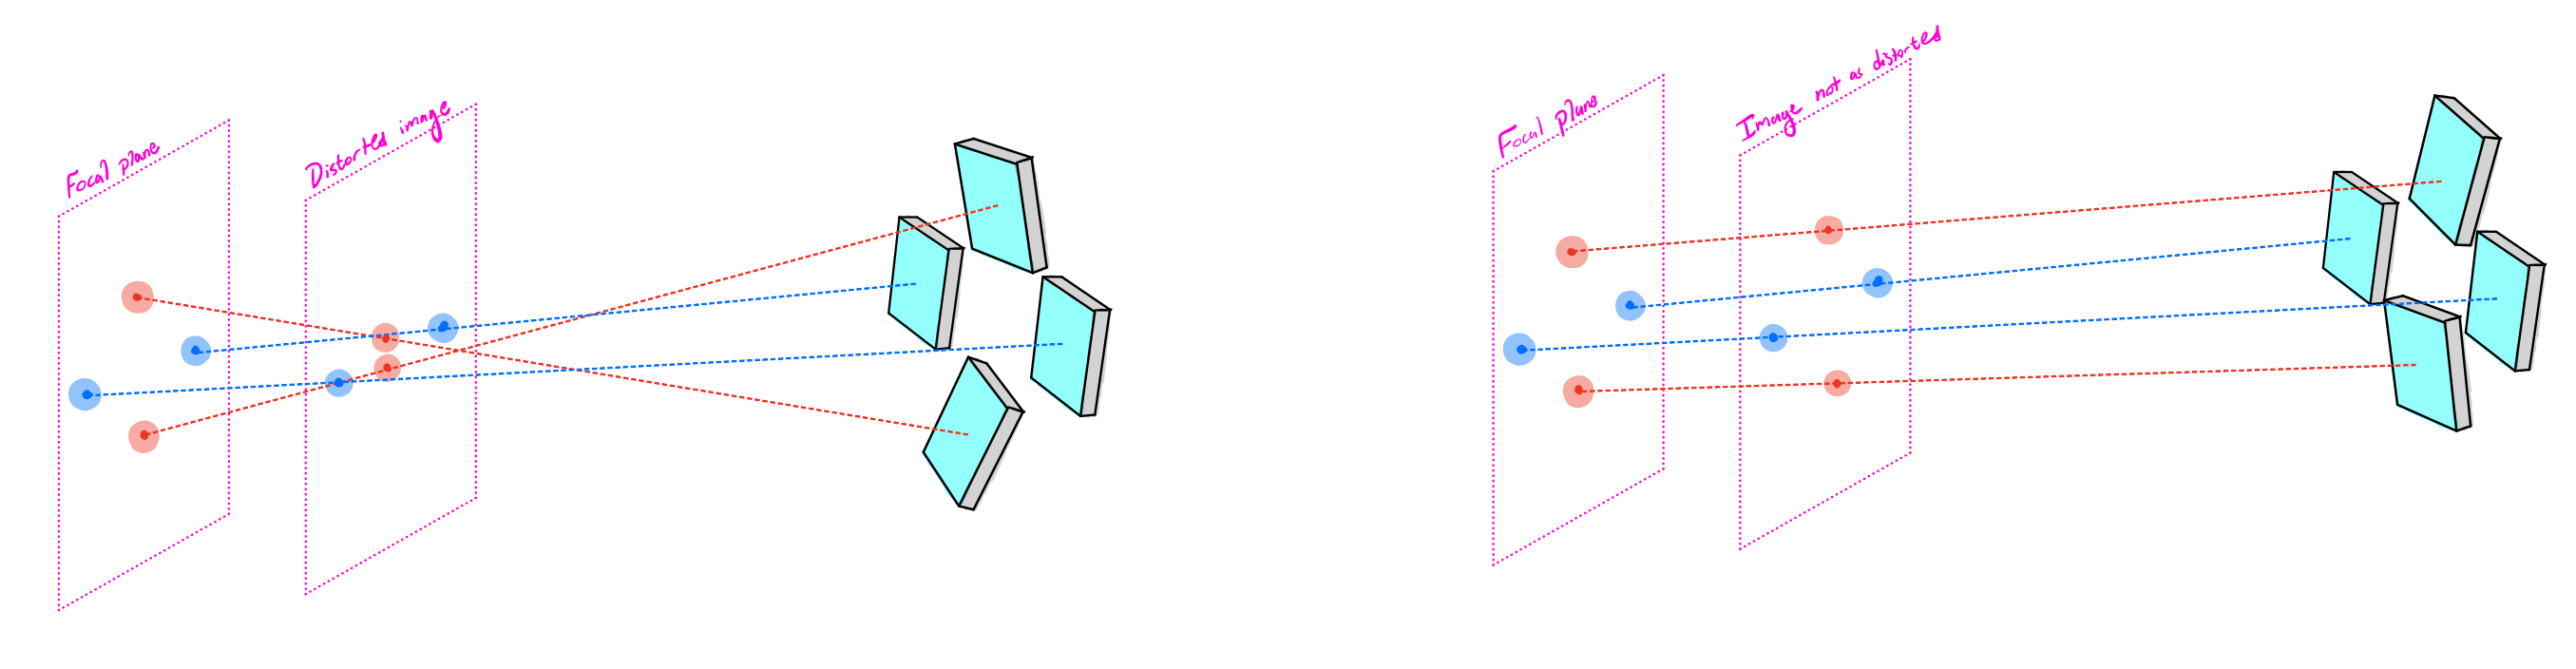

So we want to match the target points with corresponding mirrors so that the rays are as parallel as possible and minimal crossings occur. How should we do this? An early approach I took was to iterate over the mirrors and greedily assign each target to the mirror which minimizes the angle of incidence (so, minimizing the inner product of $\vec{n} \cdot \vec{u}$). However, this approach didn't work as well as I had hoped because it only considered the magnitude of this inner product rather than the direction of the reflected light beam. You can see some of the distortion in the early test prints of the heart mirrors in the next section, which used this initial matching algorithm. (Although some of that distortion was also due to poor adhesion to the print bed.)

The algorithm I ended up settling on is inspired by the structure of the hexagonal grid itself. A hexagonal grid with radius of $R$ hexagons has a number $n_R = 1 + \sum_{r=1}^R 6 \left(r-1\right)$ of mirrors. So there's one mirror at the center ($R=1$), and after that, 6 mirrors in the innermost ring ($R=2$), 12 mirrors in the next ring, then 18, and so on. To minimize ray crossings, I computed the center of mass of the target pixel coordinates, then grouped the coordinates into bins based on their distance from the center of mass, where each bin has a size equal to the number of mirrors in that ring. So the centermost target pixel gets assigned to the center mirror, then the 6 other pixels closest to the center gets assigned to the first ring, and so on. Within each bin, I ordered the target coordinates clockwise starting from the bottom coordinate, and I assigned the target to the mirrors iterated in the same order. So the outermost ring of mirrors corresponds to the outermost ring of targets, and within this set of targets, the bottom target gets assigned to the bottom mirror, the leftmost target gets assigned to the leftmost mirror, etc., as shown in the figure below.

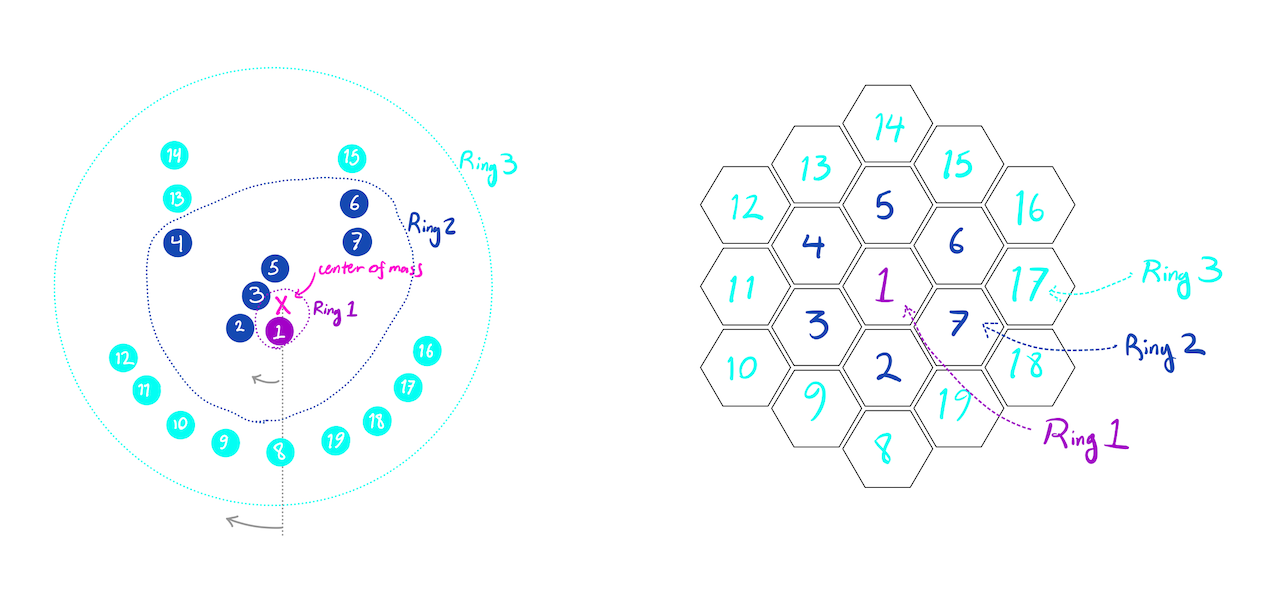

This matching algorithm ended up working quite well. (And I do love matching algorithms...) Here is a side by side comparison of the rays which form the "MARRY ME?" message when assigned to mirrors randomly (left) versus when assigned using this matching algorithm (right). You can see that the rays are much more parallel. This means that the mirror array can be held within a much wider tolerance of the correct distance from the focal plane while still projecting the message legibly.

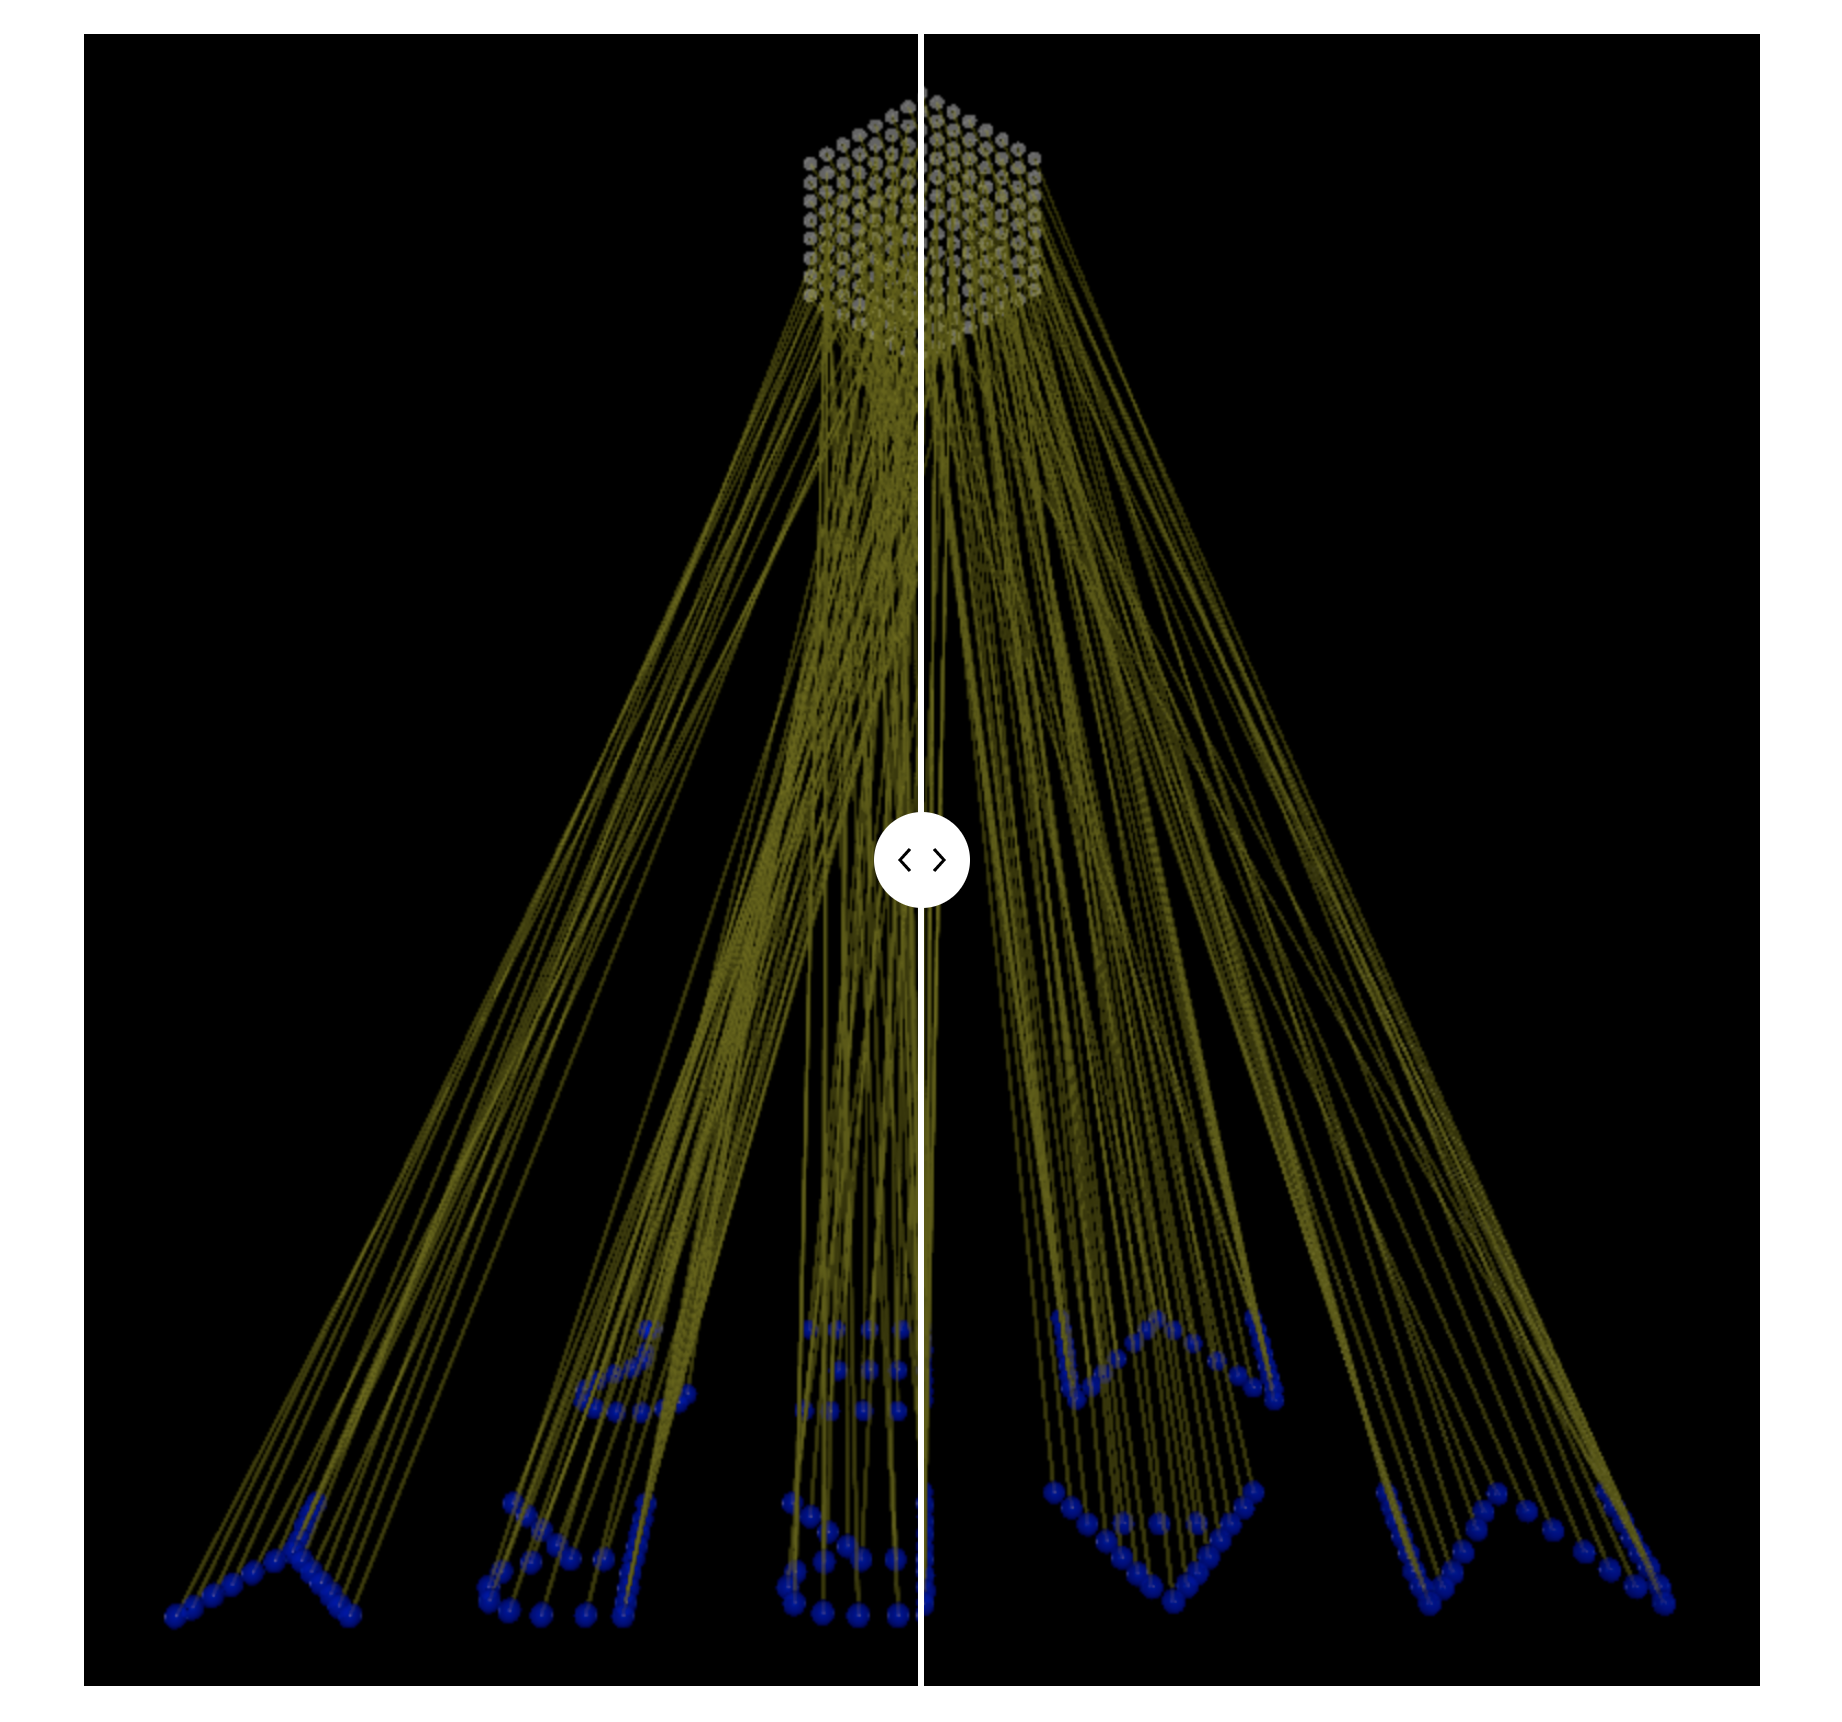

In [15]:
first_few_hex_numbers = [1 + sum(6 * (r-1) for r in range(1, radius+1)) for radius in range(1, 100)]
first_few_hex_circumferences = [1] + [6 * r for r in range(1,100)]

def is_hexagonal_number(n):
    # the really janky way of doing this
    return n in first_few_hex_numbers

def get_hex_radius(n):
    assert is_hexagonal_number(n), "must be a hex number!"
    return first_few_hex_numbers.index(n)

def divide_hex_grid_in_quarters(points):
    points = np.array(points)
    # Divide into quarters
    point_sections = np.zeros(len(points))
    for i, point in enumerate(points):
        x, y, z = point
        if x >= 0 and y >= 0:
            point_sections[i] = 0
        elif x >= 0 and y < 0:
            point_sections[i] = 1
        elif x < 0 and y >= 0:
            point_sections[i] = 2
        else:
            point_sections[i] = 3
    return point_sections

def divide_hex_grid_flower(points, hex_radius=None):
    if hex_radius is None: # copied from build_mirror_array()
        mini_hex_radius = (10 * 2.5 / 2) + 1 
        hex_radius = mini_hex_radius * 1.1
    points = np.array(points)
    # Divide into quarters
    point_sections = np.ones(len(points)) * -1
    for i, point in enumerate(points):
        x, y, z = point
        if np.sqrt(x**2 + y**2) <= 3 * (2*hex_radius + 1) * np.sqrt(3)/2:
            point_sections[i] = 0
        else:
            θ = np.arctan2(x,y) + pi - 1e-10
            point_sections[i] = 1 + np.floor(6 * θ / (2 * pi))
    return point_sections

def partition_and_save_models(hex_prisms, base_prisms, point_sections, filename = "hex_prism_grid.stl"):
    num_sections = len(set(point_sections))
    for section in range(num_sections):
        base_prisms_section = [base for (i, base) in enumerate(base_prisms) if point_sections[i]==section]
        hex_prisms_section = [hex_prism for (i, hex_prism) in enumerate(hex_prisms) if point_sections[i]==section]
        hex_prism_grid_section_combined = fuse_models([*hex_prisms_section, *base_prisms_section])
        section_filename = filename[0:-4] + "_section{}".format(section) + filename[-4:]
        hex_prism_grid_section_combined.save(section_filename)  

In [16]:
def sort_by_predicate(arr, predicate):
    '''Sort a numpy array by a predicate (along axis=0) because for some reason this isn't a standard method'''
    l = list(arr)
    l.sort(key=lambda element: predicate(element))
    return np.array(l)


def build_mirror_array(target_coordinates, filename = "hex_prism_grid.stl", depth = focal_plane_default, divider_function=None, use_ground_target=False):
    
    assert is_hexagonal_number(len(target_coordinates)), "coordinates must have hex number of targets!"
    
    # New sorting scheme:
    # 1. Group target coords into hex-number sized buckets based on the distance from the center of mass
    # 2. Sort target coords in each bucket based on angle from vertical-down
    # 3. Match each point to the corresponding mirror in that radius
    target_coords_by_bucket = []
    center_of_mass = np.mean(target_coordinates, axis=0)
    target_coords_sorted_by_radius = sort_by_predicate(target_coordinates, lambda c: np.linalg.norm(c - center_of_mass))
    
    # group target coords by radius into bins
    r_hex = get_hex_radius(len(target_coordinates))
    target_coords_grouped_by_radius = np.split(target_coords_sorted_by_radius, first_few_hex_numbers[0:r_hex])

    # computes the COUNTERCLOCKWISE angle from the bottom. necessary because mirrors are enumerate counterclockwise.
    def angle_from_bottom(coord):
        line_from_com = coord - center_of_mass
        x, y = line_from_com
        angle_from_bottom = -1 * (np.arctan2(x,y) - pi - 1e-10)
        return angle_from_bottom
    
    # sort each bin by angle from bottom and append to master list
    target_coordinates_sorted = []
    for target_coords_in_bin in target_coords_grouped_by_radius:
        target_coords_sorted_by_angle = sort_by_predicate(target_coords_in_bin, lambda c: angle_from_bottom(c))
        target_coordinates_sorted += list(target_coords_sorted_by_angle)
    target_coordinates_sorted = np.array(target_coordinates_sorted)
    
    if use_ground_target:
        target_positions_sorted = create_target_positions_ground(target_coordinates_sorted)
    else:
        target_positions_sorted = create_target_positions_wall(target_coordinates_sorted, depth=depth)

    θ = np.deg2rad(10) # This is the angle with respect to the XY plane, normal to the overall structure
    ϕ = np.deg2rad(0)
    
    v_sun = np.array([sin(ϕ), cos(ϕ) * sin(θ), cos(ϕ) * cos(θ)])

    grid_hex_radius = first_few_hex_numbers.index(len(target_positions_sorted))
    assert grid_hex_radius >= 1
    
    mini_hex_radius = (10 * 2.5 / 2) + 1 # +1 for aligner
    hex_base_radius = mini_hex_radius * 1.1

    hex_centers = get_hex_grid_centers(grid_hex_radius, hex_base_radius)
        
    mirror_positions = [mirror_pos_from_xy_base(center, base_height=24, distance_scaling=-.07) for center in hex_centers]

    # # OLD ALGORITHM: Sort the target positions so that each mirror has (greedily) the closest target position
    # remaining_target_positions = copy.deepcopy(target_positions)
    # target_positions_sorted = []
    # for mirror_pos in mirror_positions: 
    #     possible_normal_vecs = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for target_pos in remaining_target_positions]
    #     alignments = [np.abs(v_sun @ v_normal) for v_normal in possible_normal_vecs]
    #     best_alignment_index = np.argmax(alignments)
    #     target_positions_sorted.append(remaining_target_positions[best_alignment_index])
    #     remaining_target_positions = np.delete(remaining_target_positions, best_alignment_index, 0)    
        
    mirror_normals = [compute_mirror_normal(mirror_pos, target_pos, θ, ϕ) for mirror_pos, target_pos in zip(mirror_positions, target_positions_sorted)]

    base_positions = [mirror_pos_from_xy_base(center, base_height=5, distance_scaling=0) for center in hex_centers]
    base_normals = np.tile(np.array([0,0,1]), (len(hex_centers),1))
    
    if divider_function is not None:
        point_sections = divider_function(mirror_positions)
        hex_prisms = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True, no_fuse_models=True)
        base_prisms = make_hex_prism_grid(base_positions, base_normals, hex_base_radius * 1.01, add_mirror_aligners=False, no_fuse_models=True)
        #partition_and_save_models(hex_prisms, base_prisms, point_sections, filename=filename)
    else:
        hex_prism_grid = make_hex_prism_grid(mirror_positions, mirror_normals, mini_hex_radius, add_mirror_aligners=True)
        base_grid = make_hex_prism_grid(base_positions, base_normals, hex_base_radius * 1.01, add_mirror_aligners=False)
        hex_prism_grid_combined = fuse_models([hex_prism_grid, base_grid])
        #hex_prism_grid_combined.save(filename)
    
    return mirror_positions, mirror_normals, target_positions_sorted

In [17]:
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords, use_ground_target=True, filename="hex_prism_grid_main.stl", divider_function=divide_hex_grid_flower)
mirror_positions, mirror_normals, target_positions = build_mirror_array(coords, use_ground_target=True, filename="hex_prism_grid_main.stl", divider_function=None)

Created model with 169 hex prisms
Created model with 169 hex prisms
Created model with 169 hex prisms
Created model with 169 hex prisms


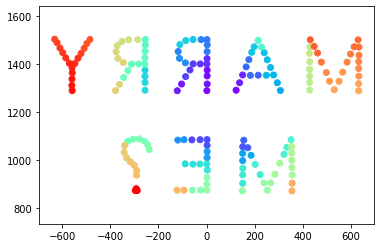

In [18]:
plt.scatter(target_positions[:,0], target_positions[:,2], c=np.arange(len(target_positions)), cmap="rainbow")
plt.axis("equal")
plt.show()

In [19]:
# # mirror_positions, mirror_normals, target_positions = build_mirror_array(coords_heart, depth=focal_plane_default, filename="hex_prism_grid_heart.stl")
# mirror_positions, mirror_normals, target_positions = build_mirror_array(coords_heart, use_ground_target=True, filename="hex_prism_grid_heart.stl")

In [20]:
# # mirror_positions, mirror_normals, target_positions = build_mirror_array(coords, use_ground_target=True, filename="hex_prism_grid_main.stl", divider_function=divide_hex_grid_flower)
# mirror_positions, mirror_normals, target_positions = build_mirror_array(coords_test, use_ground_target=True, filename="hex_prism_grid_test.stl", divider_function=None)

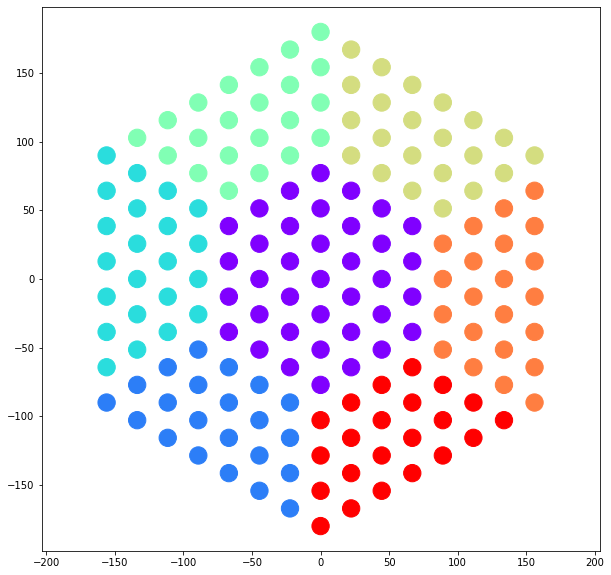

In [21]:
# Demonstrate the flower-petal model partitioning scheme I'm using

def plot_hex_points(points):
    plt.figure(figsize=(10,10))
    points = np.array(points)
    # Divide into quarters
    point_sections = divide_hex_grid_flower(points, 14.85)
    plt.scatter(points.T[0], points.T[1], c=point_sections, s=300.0, cmap="rainbow")
    plt.axis("equal")
    plt.show()
    
plot_hex_points(mirror_positions)

# Visualization code for debugging

This cell renders a 3D visualization of the mirror angles and the rays projected by the mirrors.

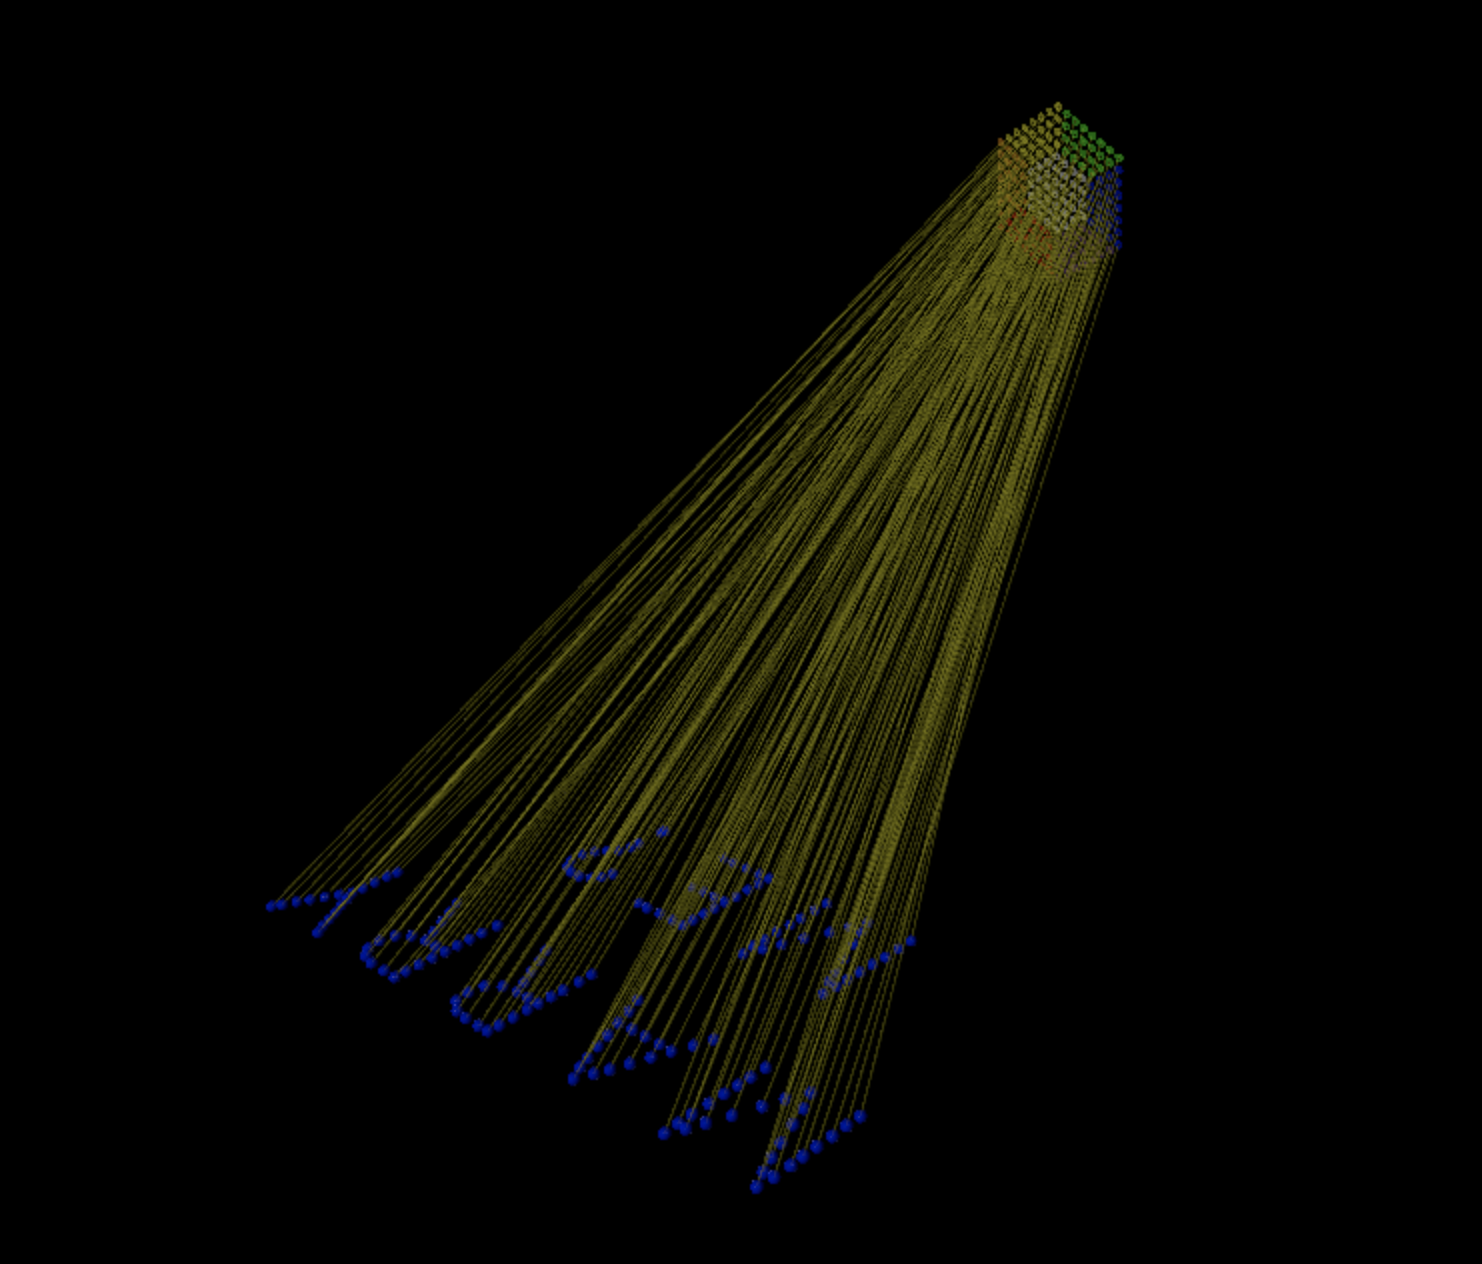

In [23]:
# if scene:
#     scene.delete()
scene = vis.canvas(width=1200, height=1200)
vis.rate(10)

def vec_arrow(pos, axis, color=vis.color.yellow):
    return vis.cylinder(pos=pos, axis=axis, radius=2.0, color=color, opacity=0.2)

def np_to_vec(np_arr):
    return vec(*(np_arr))

def add_mirror_target(mirror_pos, mirror_normal, target_pos, mirror_color=vis.color.white):

    target = vis.sphere(pos = target_pos, radius = 10, color = vis.color.blue, opacity=0.5)
    mirror = vis.cylinder(pos = mirror_pos, radius = 10, axis = -0.5 * mirror_normal.norm(), color = mirror_color, opacity=0.5)

    v_target_mirror = mirror_pos - target_pos

#     arrow_target_pos = vec_arrow(pos=vec(0,0,0), axis=target_pos)
#     arrow_mirror_pos = vec_arrow(pos=vec(0,0,0), axis=mirror_pos)
    arrow_target_mirror = vec_arrow(pos=mirror_pos, axis=-1*v_target_mirror, color=vis.color.yellow)
#     arrow_mirror_sun = vec_arrow(pos=mirror_pos, axis=50 * v_mirror_sun, color=vis.color.red)


n_points = 999

# vis.sphere(pos = vec(0,-300,0), radius = 20, color = vis.color.white, opacity=0.5)
# vis.sphere(pos = vec(300,-300,0), radius = 20, color = vis.color.red, opacity=0.5)
# vis.sphere(pos = vec(0,300-300,0), radius = 20, color = vis.color.yellow, opacity=0.5)
# vis.sphere(pos = vec(0,-300,300), radius = 20, color = vis.color.green, opacity=0.5)

mirror_positions_sections = divide_hex_grid_flower(mirror_positions)
# sections_colors = [vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white, vis.color.white]
sections_colors = [vis.color.white, vis.color.red, vis.color.orange, vis.color.yellow, vis.color.green, vis.color.blue, vis.color.purple]

for i, (mirror_pos, mirror_normal, target_pos, section) in enumerate(zip(mirror_positions, mirror_normals, target_positions, mirror_positions_sections)):
    if i >= n_points:
        break
    add_mirror_target(np_to_vec(mirror_pos), np_to_vec(mirror_normal), np_to_vec(target_pos), mirror_color = sections_colors[int(section)])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
scene.delete()